## Dataset background and introduction

*README*: I made 3 attempts in this final project, where the second one ends up with a much higher $R^2$ value for my regression model and its parity plot. Along the questions, you can see the comments with '#' where I show my first and second attempt. The un-commented one is my final answer.

Alloy plays significant roles in structures we see in our daily live has broad applications in  fields that have relation with materials. Properties and performance of alloys significantly depends on its manufacturing methods, and commonly it is done by mixing of different molten metals. In liquid molten state, metal atoms diffuse to spaces between atoms to form various composition and arrangements which then contributes to the alloy's properties. 

However, while the diffusion coefficients in the equation can be determinedd accurately from the rates of atomic vacancy exchanges around the impurity, these coefficients can only be determined empirically, which is costly and hard to carry out. Only small amount of the coefficients has been experimentally measured. This issue can be optimized by using computational methods.

This dataset is a product of a computational method that could automate generation of dilute solute diffusion systems in Mg, Al, Cu, Ni, Pd and Pt host lattices using high-throughput DFT calculations. Parameters calculated are fitted into a multi-frequency framework developed previously, expressed with Arrhenius equation:

$\omega_{i}$ = $\nu_{i}$ $\exp$ $({ \frac{-E_{i}}{k_{b}{T}} })$

where $\omega_{i}$ is jump frequency, $-E_{i}$ is migration barrier energy, $\nu_{i}$ is attempt frequencies.

In order to calculate solute diffusion coefficients in HCP and FCC hosts, the 8-frequency diffusion model and the 5-frequency diffusion model were used, corresponding to the 2 hosts.<br>

The article that describes the computational method that generated this data can be found here: https://www.nature.com/articles/sdata201654#Tab1 <br>

Data downloaded from here: https://figshare.com/articles/dataset/MAST-ML_Education_Datasets/7017254<br>

The material property this dataset seeks to predict is the effective diffusion activation energy for vacancy-mediated diffusion of a dilute solute element in a known host crystal from the migration barrier activation energy. The reported energies have all been normalized to the host value, such that each energy in a host-solute pair is the relative energy to the respective host's self-diffusion value. 


In [66]:
!pip install kneed
!pip install tensorflow-cpu==2.17.0
!pip install scikeras


import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Goal/hypothesis

Since the dataset is used to predict the migration activation barrier energy (Enorm, as in normalized migration activation energy barrier), I will need to identify features that help predict the normalized migration activation energy barrier. <br>

Hypothesis: Intuitively, I think any feature that relates to bonding strength/a proxy related to bonding strength can be used as a prediction feature, since how the atoms bond together significantly affects the amount of energy needed to take them apart. These properties can be used to create a model that predicts how much is the migration activation energy barrier. <br>

The higher the melting temperature, the higher the migration activation energy barrier; 
the more unfilled d-orbitals lead to more directional bonding, thus a higher activation energy to break the bonds. 
Besides that, the lower stability of the solute in BCC correlates with weaker bonding in the host lattice, which means a lower activation energy barrier. While radii and charges (electronegativity) of the atom is also important in bonding, these features shall also be included.



## Data preprocessing 

In [67]:
#read the dataset
df = pd.read_csv('Dilute_Solute_Diffusion_with_features.csv')

#check how many samples we have
print('Shape of data',df.shape)

#check keys 
print('\nKeys of the data:',df.keys())

#check NA values
df.isna().sum() #no NaN values, amazing!

#'Material compositions 1' and 'Material compositions 2' are string. let's map them to integer
uniq_mat = pd.unique(df[['Material compositions 1','Material compositions 2']].values.ravel())
str2int = {mat: i+1 for i, mat in enumerate(uniq_mat)}
df['mat1_mapped'] = df['Material compositions 1'].map(str2int)
df['mat2_mapped'] = df['Material compositions 2'].map(str2int) 

pop1 = df.pop('mat1_mapped')
pop2 = df.pop('mat2_mapped')

df.insert(2, 'mat1_mapped', pop1)
df.insert(3, 'mat2_mapped', pop2)

df.head()

Shape of data (408, 29)

Keys of the data: Index(['Material compositions 1', 'Material compositions 2', 'Enorm (eV)',
       'E_raw (eV)', 'Site2_MeltingT', 'Site1_MendeleevNumber',
       'Site1_MiracleRadius', 'GSestFCClatcnt_max_value', 'Site2_BCCenergy_pa',
       'Site1_BCCfermi', 'CovalentRadius_max_value', 'Site2_Density',
       'n_ws^third_min_value', 'Site1_HHIr', 'IonicRadii_max_value',
       'BoilingT_max_value', 'valence_arithmetic_average', 'Site2_NdUnfilled',
       'Site1_IonicRadii', 'BCCenergy_pa_composition_average',
       'MiracleRadius_min_value', 'MeltingT_min_value', 'NUnfilled_max_value',
       'Site2_Group', 'Site1_CovalentRadii', 'Site2_NUnfilled',
       'SpecificHeatCapacity_difference', 'Site1_Electronegativity',
       'BCCenergy_pa_arithmetic_average'],
      dtype='object')


Material compositions 1 Material compositions 2  mat1_mapped  mat2_mapped  \
0                      Ag                      Ag            1            1   
1                      Ag                      Co            1            2   
2                      Ag                      Cr            1            3   
3                      Ag                      Cu            1            4   
4                      Ag                      Fe            1            5   

   Enorm (eV)  E_raw (eV)  Site2_MeltingT  Site1_MendeleevNumber  \
0     0.00000     1.82445        -0.53181                0.40250   
1    -0.09014     1.73431         0.06405                0.40250   
2     0.25914     2.08359         0.52458                0.40250   
3    -0.02220     1.80225        -0.39450                0.40250   
4     0.31767     2.14212         0.11212                0.40250   

   Site1_MiracleRadius  GSestFCClatcnt_max_value  ...  \
0              0.26304                  -0.62692  ...   
1              0.26304                  -0.62692  ...   
2              0.26304                  -0.62692  ...   
3              0.26304                  -0.62692  ...   
4              0.26304                  -0.62692  ...   

   BCCenergy_pa_composition_average  MiracleRadius_min_value  \
0                           1.38657                  0.85981   
1                           0.48485                 -0.73018   
2                          -0.04955                 -0.31176   
3                           1.19122                 -0.64650   
4                           0.20854                 -0.73018   

   MeltingT_min_value  NUnfilled_max_value  Site2_Group  Site1_CovalentRadii  \
0            -0.04611             -1.54656      0.62661              0.69029   
1            -0.04611             -0.80158      0.11632              0.69029   
2            -0.04611              0.31589     -0.64913              0.69029   
3            -0.04611             -1.54656      0.62661              0.69029   
4            -0.04611             -0.42909     -0.13883              0.69029   

   Site2_NUnfilled  SpecificHeatCapacity_difference  Site1_Electronegativity  \
0         -1.03632                         -1.05790                  0.09947   
1         -0.39129                         -0.38861                  0.09947   
2          0.57626                         -0.28786                  0.09947   
3         -1.03632                         -0.51815                  0.09947   
4         -0.06877                         -0.28786                  0.09947   

   BCCenergy_pa_arithmetic_average  
0                          1.38657  
1                          0.48485  
2                         -0.04955  
3                          1.19122  
4                          0.20854  

[5 rows x 31 columns]

## Visualization 

I start by checking the correlation between the features to narrow down which to pick. Correlation is purely statistical; it can have no meaning at all (explanation in the discussion before machine learning methods). Then I check their pairwise $R^2$ value while mapped to Enorm. After that, I also check the collinearity between the features. Lastly, I combined all possible variable pairs together and checked their $R^2$ values while mapped to Enorm. 

This step helps visualize the structure and check which feature to extract to train a model that could predict the migration energy barrier based on given properties. I can do a visualization to check the trend between the keys in both 3D and 2D plots against Enorm. 

Let's check for correlation between the features and have a general idea of the structure of the dataset


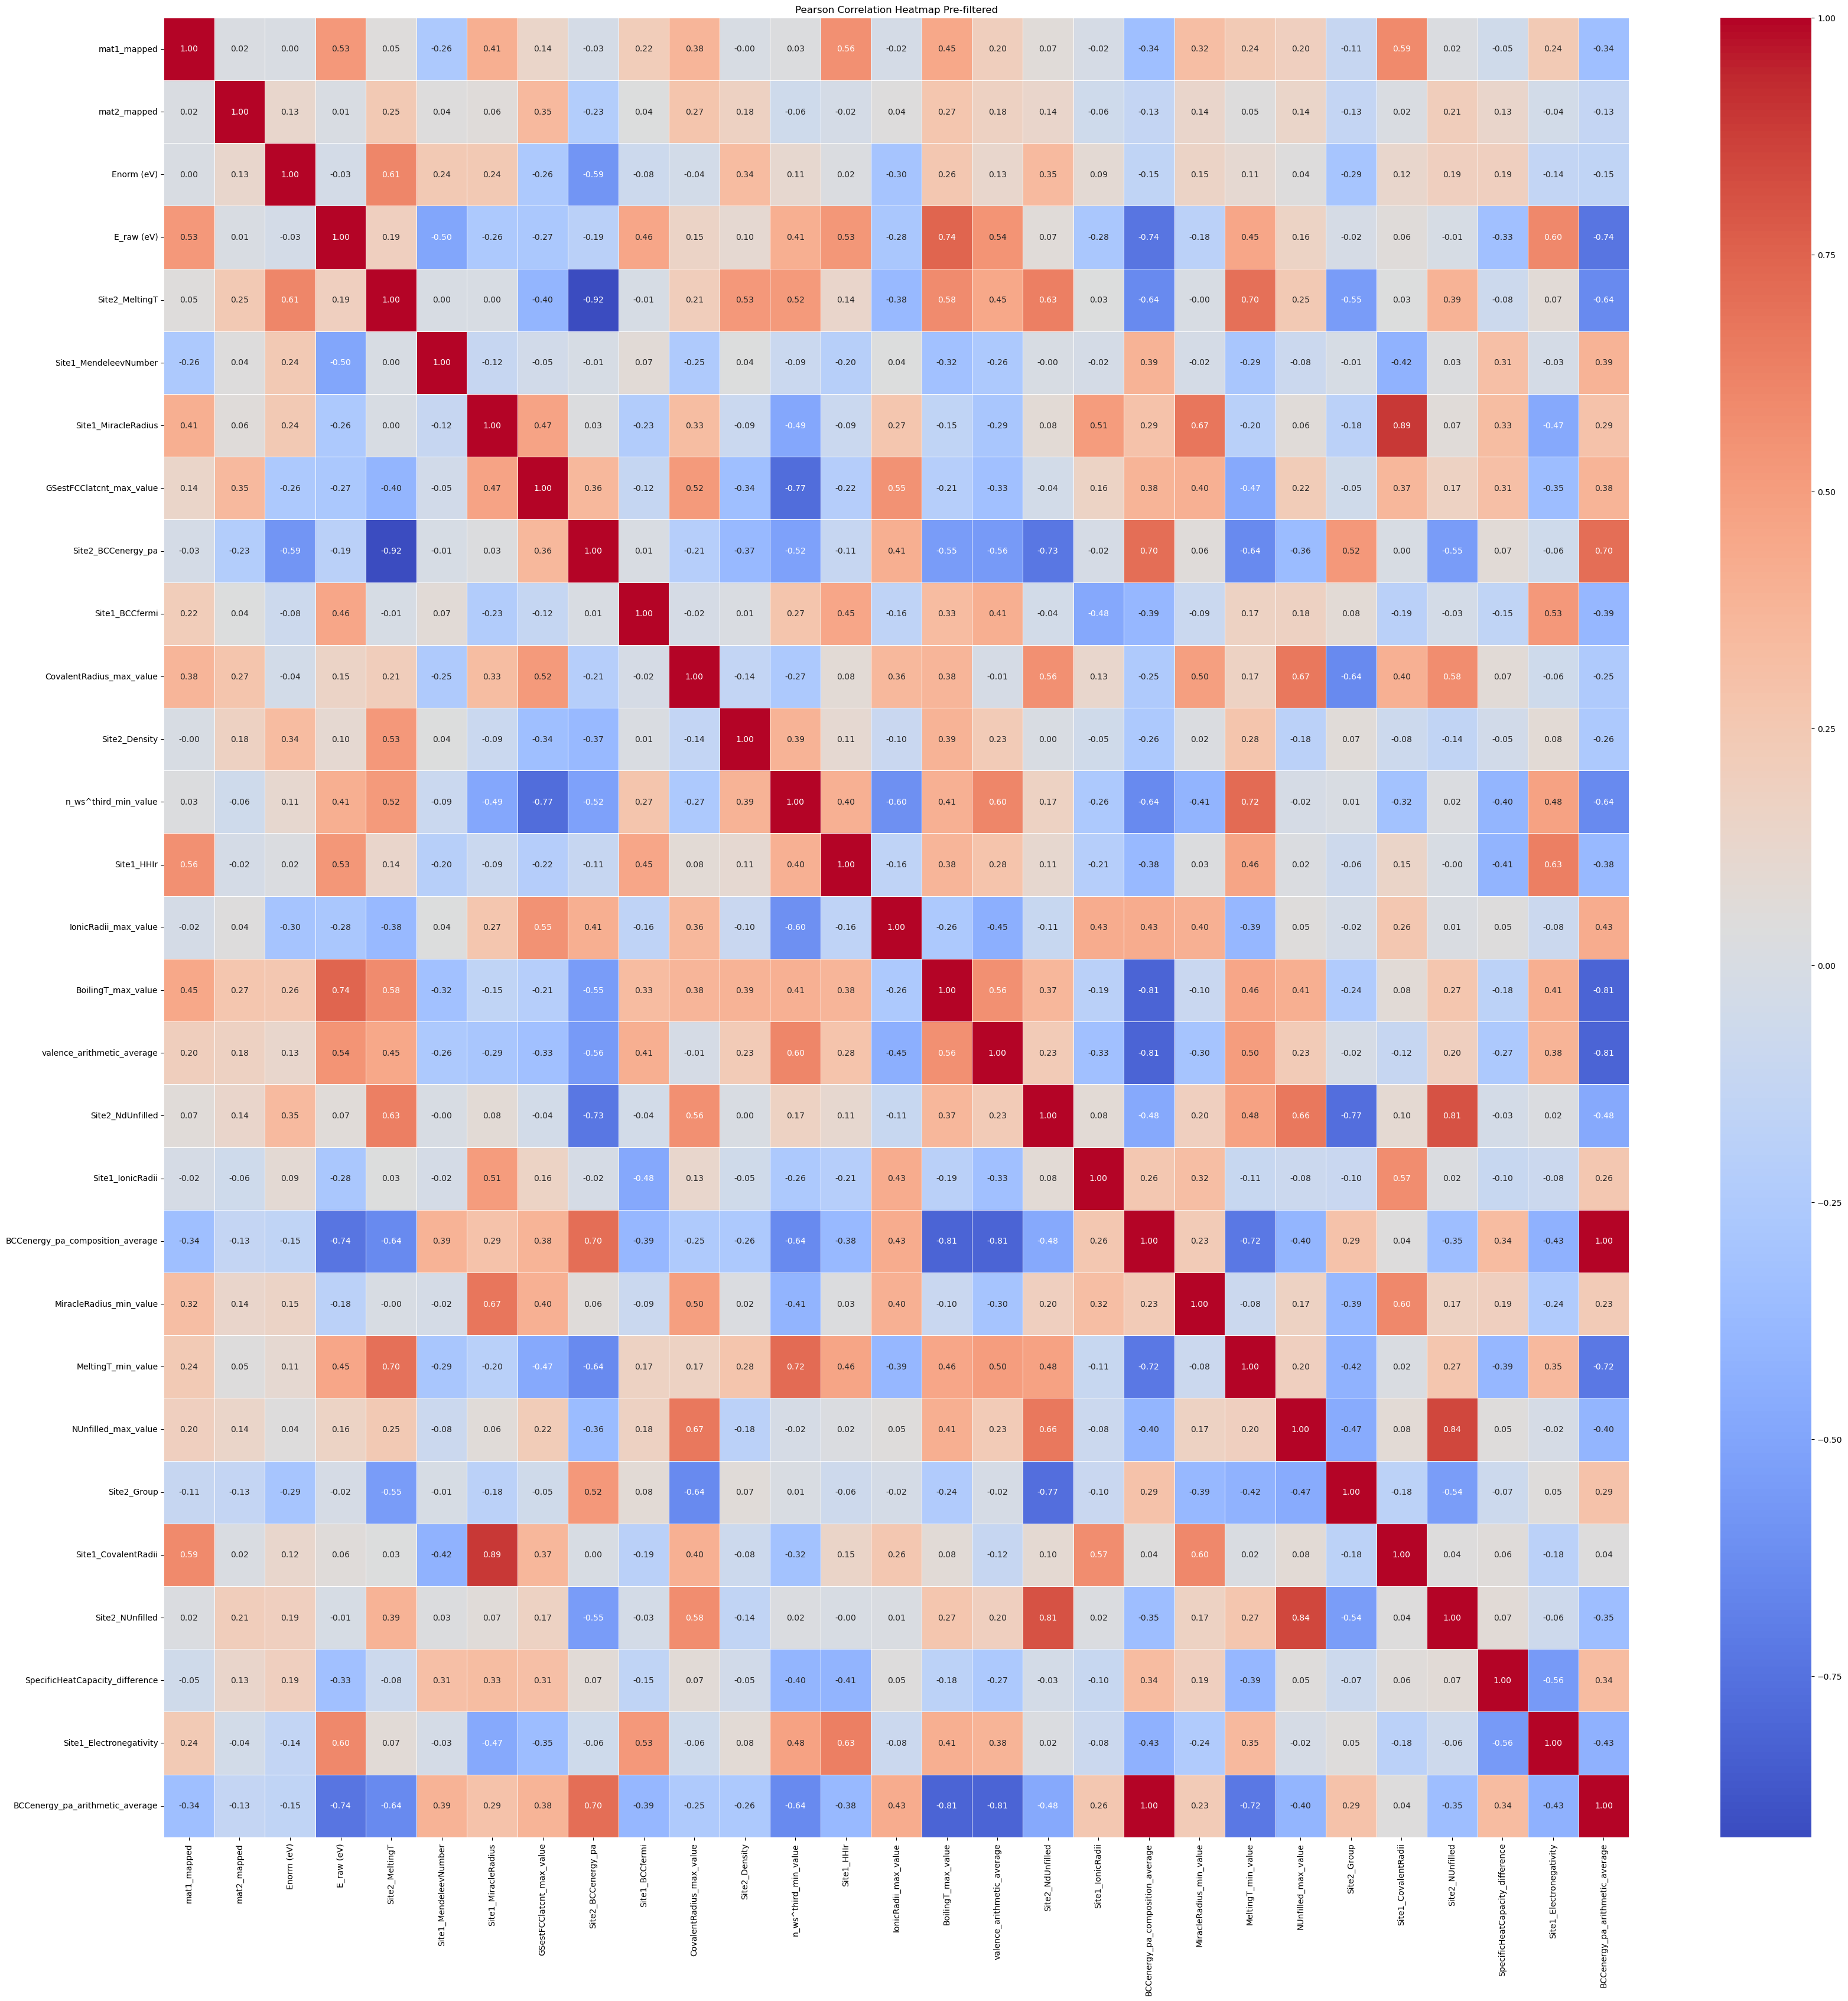

In [68]:
map_df = df.iloc[:,2:]
cor = map_df.corr()
plt.figure(figsize=(40, 40)) 
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Heatmap Pre-filtered')
plt.show()


The heatmap shows the following keys are highly correlated to Enorm:

Site2_MeltingT - melting temperature of solute<br>
Site2_BCCenergy_pa - per-atom DFT energy of the solute placed in a BCC structure, even if the solute is not BCC in reality.<br>
Site2_Density - density of solute<br>
Site2_NdUnfilled - number of unfilled d-electrons (d-band vacancies) of the solute element.<br>
Site2_Group - group of solute <br>

Let's check their<br> 
1.) pairwise $R^2$ values mapped to Enorm, <br>
2.) combined possible variable pairs and their $R^2$ values while mapped to Enorm. <br>
3.) collinearity between the features themselves,<br>


Using 26 valid numeric features.



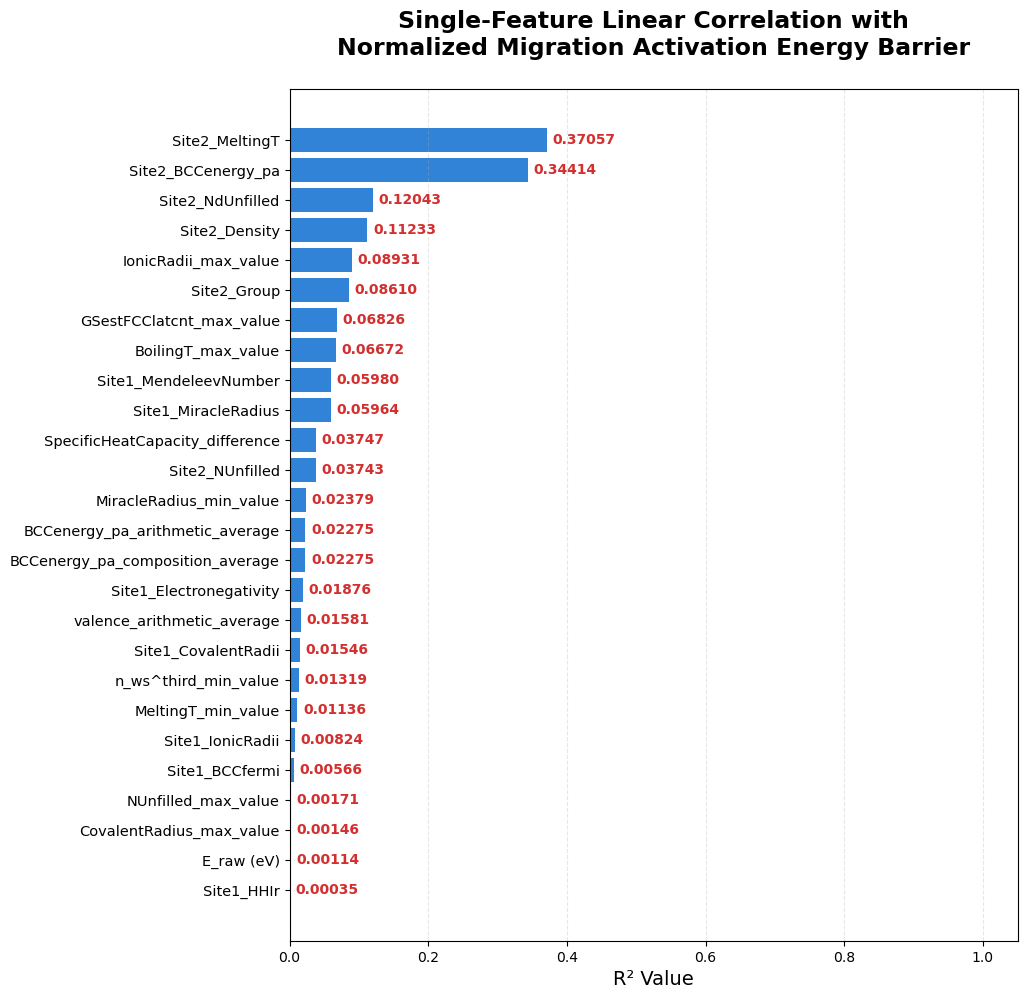

                   Single feature R^2 ranking mapped to Enorm                   


   → 100 pairs processed...
   → 200 pairs processed...
   → 300 pairs processed...

Finished! Found 325 valid pairwise combinations.



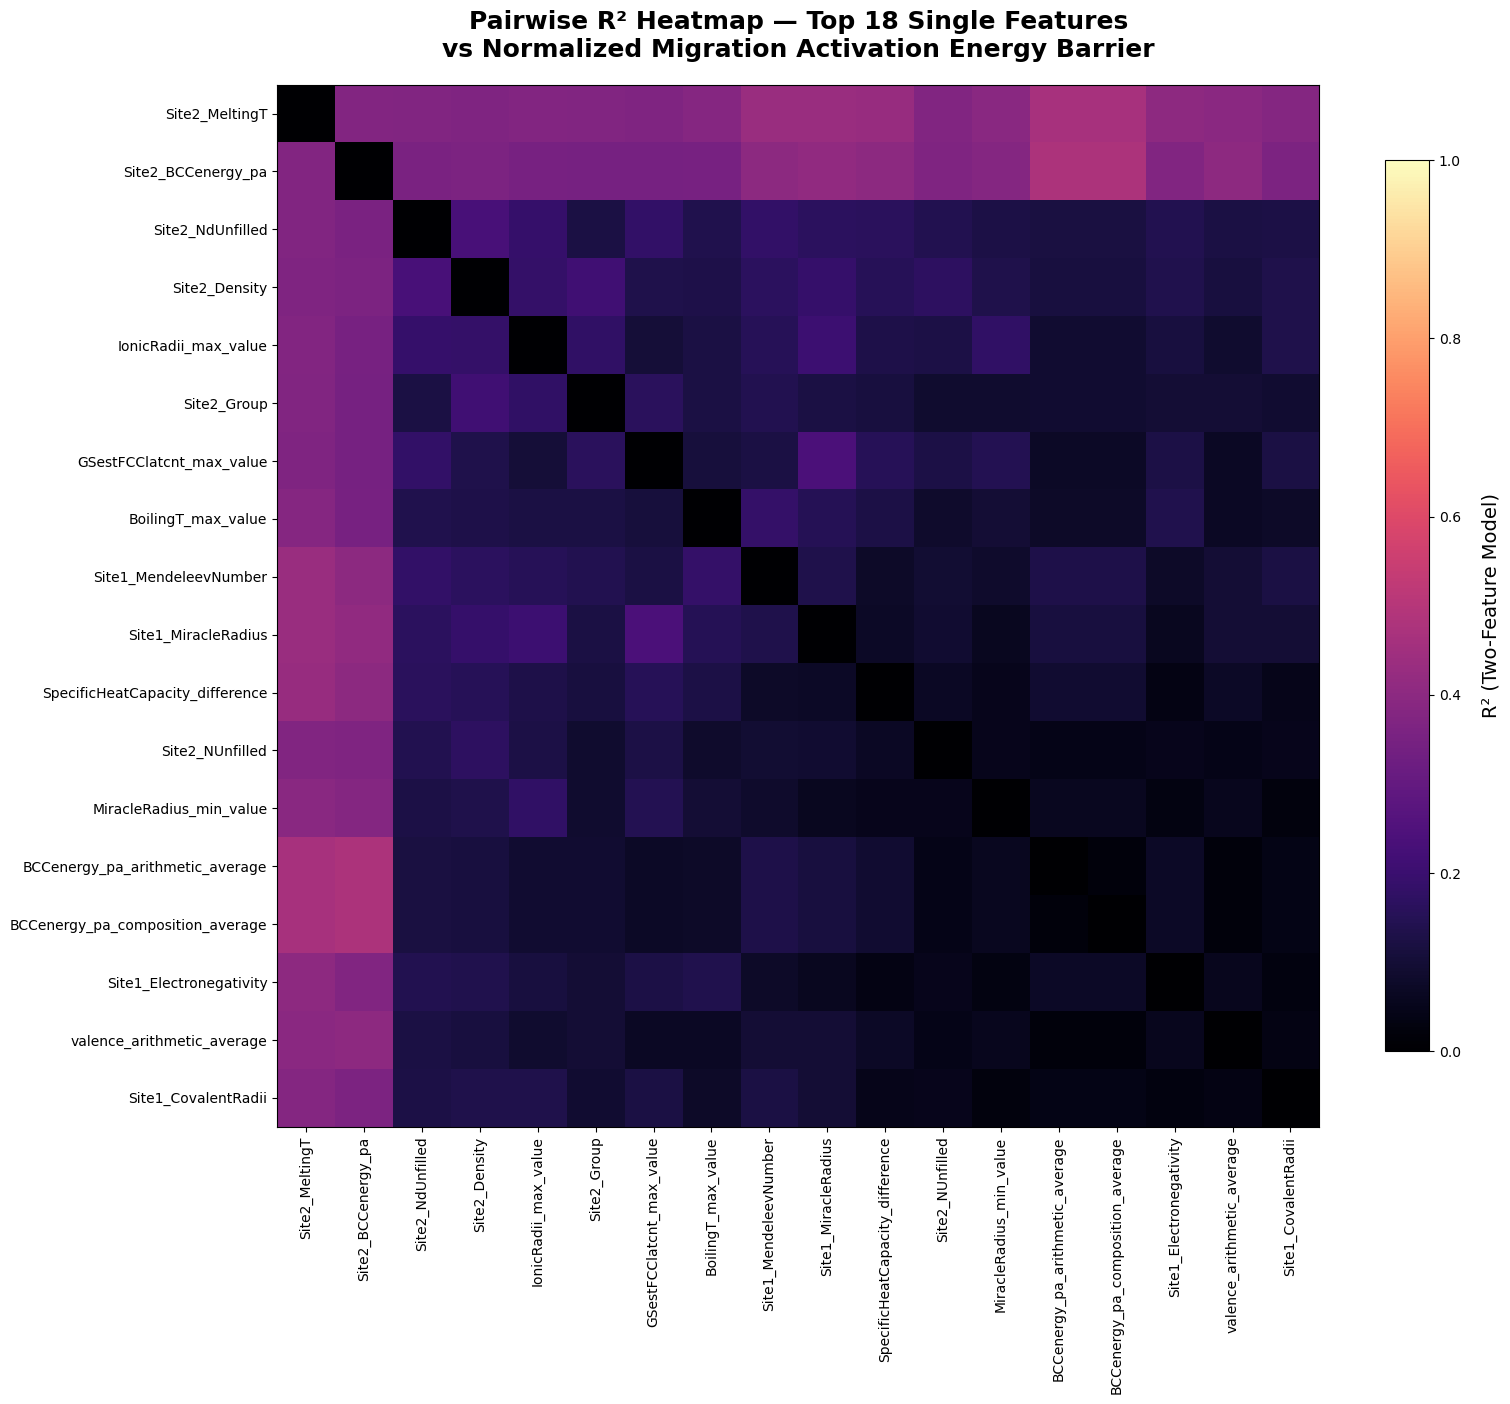

                                      highest 30 feature pairs                                      


In [69]:

from scipy.stats import linregress
from itertools import combinations


df = map_df.copy()
target = 'Enorm (eV)'

all_columns = [
    'Material compositions 1', 'Material compositions 2', 'Enorm (eV)', 'E_raw (eV)',
    'Site2_MeltingT', 'Site1_MendeleevNumber', 'Site1_MiracleRadius',
    'GSestFCClatcnt_max_value', 'Site2_BCCenergy_pa', 'Site1_BCCfermi',
    'CovalentRadius_max_value', 'Site2_Density', 'n_ws^third_min_value',
    'Site1_HHIr', 'IonicRadii_max_value', 'BoilingT_max_value',
    'valence_arithmetic_average', 'Site2_NdUnfilled', 'Site1_IonicRadii',
    'BCCenergy_pa_composition_average', 'MiracleRadius_min_value',
    'MeltingT_min_value', 'NUnfilled_max_value', 'Site2_Group',
    'Site1_CovalentRadii', 'Site2_NUnfilled', 'SpecificHeatCapacity_difference',
    'Site1_Electronegativity', 'BCCenergy_pa_arithmetic_average'
]

features = []
for col in all_columns:
    if col in df.columns and col != target and pd.api.types.is_numeric_dtype(df[col]):
        if df[col].nunique() > 1:
            features.append(col)

print(f"Using {len(features)} valid numeric features.\n")


################### single feature r^2 plot

r2_single = []
for feat in features:
    data = df[[feat, target]].dropna()
    if len(data) >= 3:
        r2 = linregress(data[feat], data[target]).rvalue ** 2
        r2_single.append({'Feature': feat, 'R²': round(r2, 5)})

df_single = pd.DataFrame(r2_single).sort_values('R²', ascending=False).reset_index(drop=True)


fig, ax = plt.subplots(figsize=(13, max(9, len(df_single)*0.42)))
y_pos = np.arange(len(df_single))
bars = ax.barh(y_pos, df_single['R²'], color='#1976d2', alpha=0.9, height=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(df_single['Feature'], fontsize=10.5)
ax.set_xlabel('R² Value', fontsize=14)
ax.set_title('Single-Feature Linear Correlation with\nNormalized Migration Activation Energy Barrier',
              fontsize=17, fontweight='bold', pad=25)
ax.set_xlim(0, 1.05)
ax.grid(True, axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

for i, val in enumerate(df_single['R²']):
    ax.text(val + 0.008, i, f'{val:.5f}', va='center', fontsize=10, fontweight='bold', color='#d32f2f')

plt.subplots_adjust(left=0.42, right=0.98, top=0.90, bottom=0.12)
plt.show()

print("Single feature R^2 ranking mapped to Enorm".center(80))
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.5f}'.format)
display(df_single.style
        .bar(subset=['R²'], color='#90caf9')
        .set_properties(**{'font-size': '12pt', 'font-family': 'Calibri'})
        .set_table_styles([{'selector': 'th', 'props': [('font-size', '13pt')]}])
        .format({'R²': '{:.5f}'})
        .background_gradient(subset=['R²'], cmap='Blues'))

################### pair r^2 plot

r2_pairs = []
for i, (f1, f2) in enumerate(combinations(features, 2)):
    if i % 100 == 0 and i > 0:
        print(f"   → {i} pairs processed...")
    data = df[[f1, f2, target]].dropna()
    if len(data) < 5:
        continue
    X = np.column_stack((data[f1], data[f2], np.ones(len(data))))
    y = data[target]
    try:
        coeffs = np.linalg.lstsq(X, y, rcond=None)[0]
        y_pred = X @ coeffs
        r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - y.mean())**2)
        if r2 > 0:
            r2_pairs.append({'Feature 1': f1, 'Feature 2': f2, 'R²': round(r2, 5)})
    except:
        continue

df_pairs = pd.DataFrame(r2_pairs).sort_values('R²', ascending=False).reset_index(drop=True)
print(f"\nFinished! Found {len(df_pairs)} valid pairwise combinations.\n")

# Heatmap (top 18 features)
top_n = min(18, len(df_single))
top_features = df_single.head(top_n)['Feature'].tolist()
n = len(top_features)
matrix = np.zeros((n, n))
for _, row in df_pairs.iterrows():
    if row['Feature 1'] in top_features and row['Feature 2'] in top_features:
        i = top_features.index(row['Feature 1'])
        j = top_features.index(row['Feature 2'])
        matrix[i, j] = matrix[j, i] = row['R²']

fig, ax = plt.subplots(figsize=(16, 14))
im = ax.imshow(matrix, cmap='magma', vmin=0, vmax=1)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(top_features, rotation=90, fontsize=10)
ax.set_yticklabels(top_features, fontsize=10)
ax.set_title(f'Pairwise R² Heatmap — Top {top_n} Single Features\nvs Normalized Migration Activation Energy Barrier',
             fontsize=18, fontweight='bold', pad=20)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('R² (Two-Feature Model)', fontsize=14, labelpad=15)

for i in range(n):
    for j in range(i+1, n):
        if matrix[i,j] > 0.8:
            ax.text(j, i, f'{matrix[i,j]:.3f}', ha='center', va='center',
                    color='white', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("highest 30 feature pairs".center(100))
top_30 = df_pairs.head(30).copy()
top_30.index = range(1, len(top_30)+1)

display(top_30.style
        .bar(subset=['R²'], color='#ff9999')
        .set_properties(**{'font-size': '13pt', 'font-family': 'Arial'})
        .background_gradient(subset=['R²'], cmap='Reds')
        .format({'R²': '{:.5f}'})
        .set_table_styles([
            {'selector': 'th', 'props': [('font-size', '14pt'), ('background-color', '#ffcdd2')]},
            {'selector': 'td', 'props': [('padding', '10px')]}
        ]))


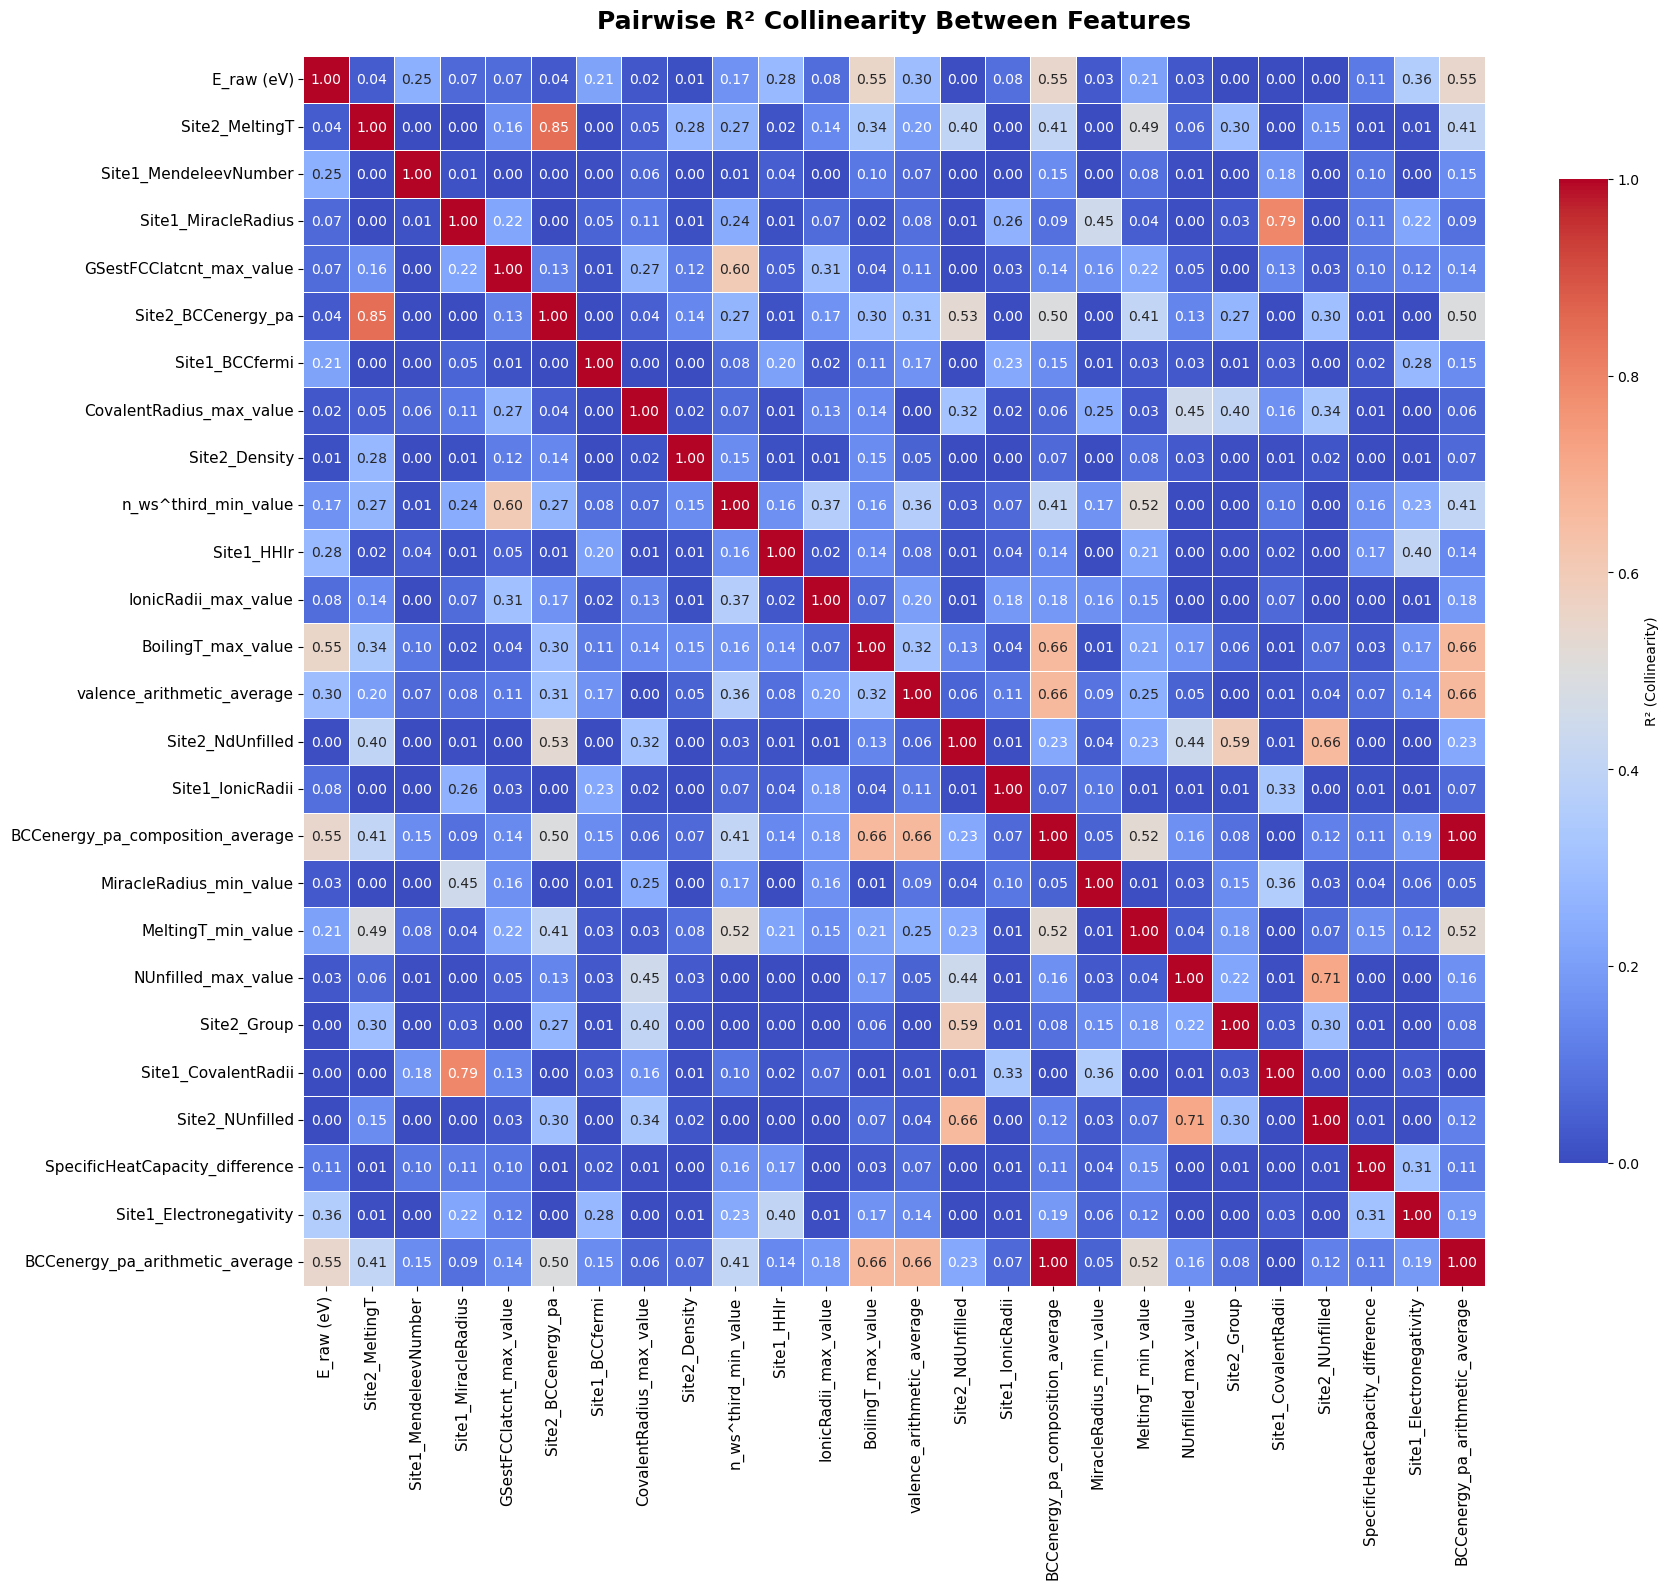

In [70]:
#collinearity plot
df = map_df.copy()

features = [
    'E_raw (eV)', 'Site2_MeltingT', 'Site1_MendeleevNumber', 'Site1_MiracleRadius',
    'GSestFCClatcnt_max_value', 'Site2_BCCenergy_pa', 'Site1_BCCfermi',
    'CovalentRadius_max_value', 'Site2_Density', 'n_ws^third_min_value',
    'Site1_HHIr', 'IonicRadii_max_value', 'BoilingT_max_value',
    'valence_arithmetic_average', 'Site2_NdUnfilled', 'Site1_IonicRadii',
    'BCCenergy_pa_composition_average', 'MiracleRadius_min_value',
    'MeltingT_min_value', 'NUnfilled_max_value', 'Site2_Group',
    'Site1_CovalentRadii', 'Site2_NUnfilled', 'SpecificHeatCapacity_difference',
    'Site1_Electronegativity', 'BCCenergy_pa_arithmetic_average'
]

valid_features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f]) and df[f].nunique() > 1]

num_df = df[valid_features]

corr = num_df.corr(method='pearson')
r2_matrix = corr ** 2

fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(r2_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1,
            linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8, 'label': 'R² (Collinearity)'})
ax.set_title('Pairwise R² Collinearity Between Features', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=11)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

pairs = []
for i in range(len(valid_features)):
    for j in range(i+1, len(valid_features)):
        r2 = r2_matrix.iloc[i, j]
        pairs.append({'Feature 1': valid_features[i], 'Feature 2': valid_features[j], 'R²': round(r2, 4)})

df_collinear = pd.DataFrame(pairs).sort_values('R²', ascending=False).reset_index(drop=True)

display(df_collinear.head(30).style
        .bar(subset=['R²'], color='#e57373')
        .background_gradient(subset=['R²'], cmap='Reds')
        .format({'R²': '{:.4f}'})
        .set_properties(**{'font-size': '13pt', 'text-align': 'left'})
        .set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt'), ('background-color', '#ffcdd2')]}]))

Let's do some 3D and 2D $R^2$ visualization 

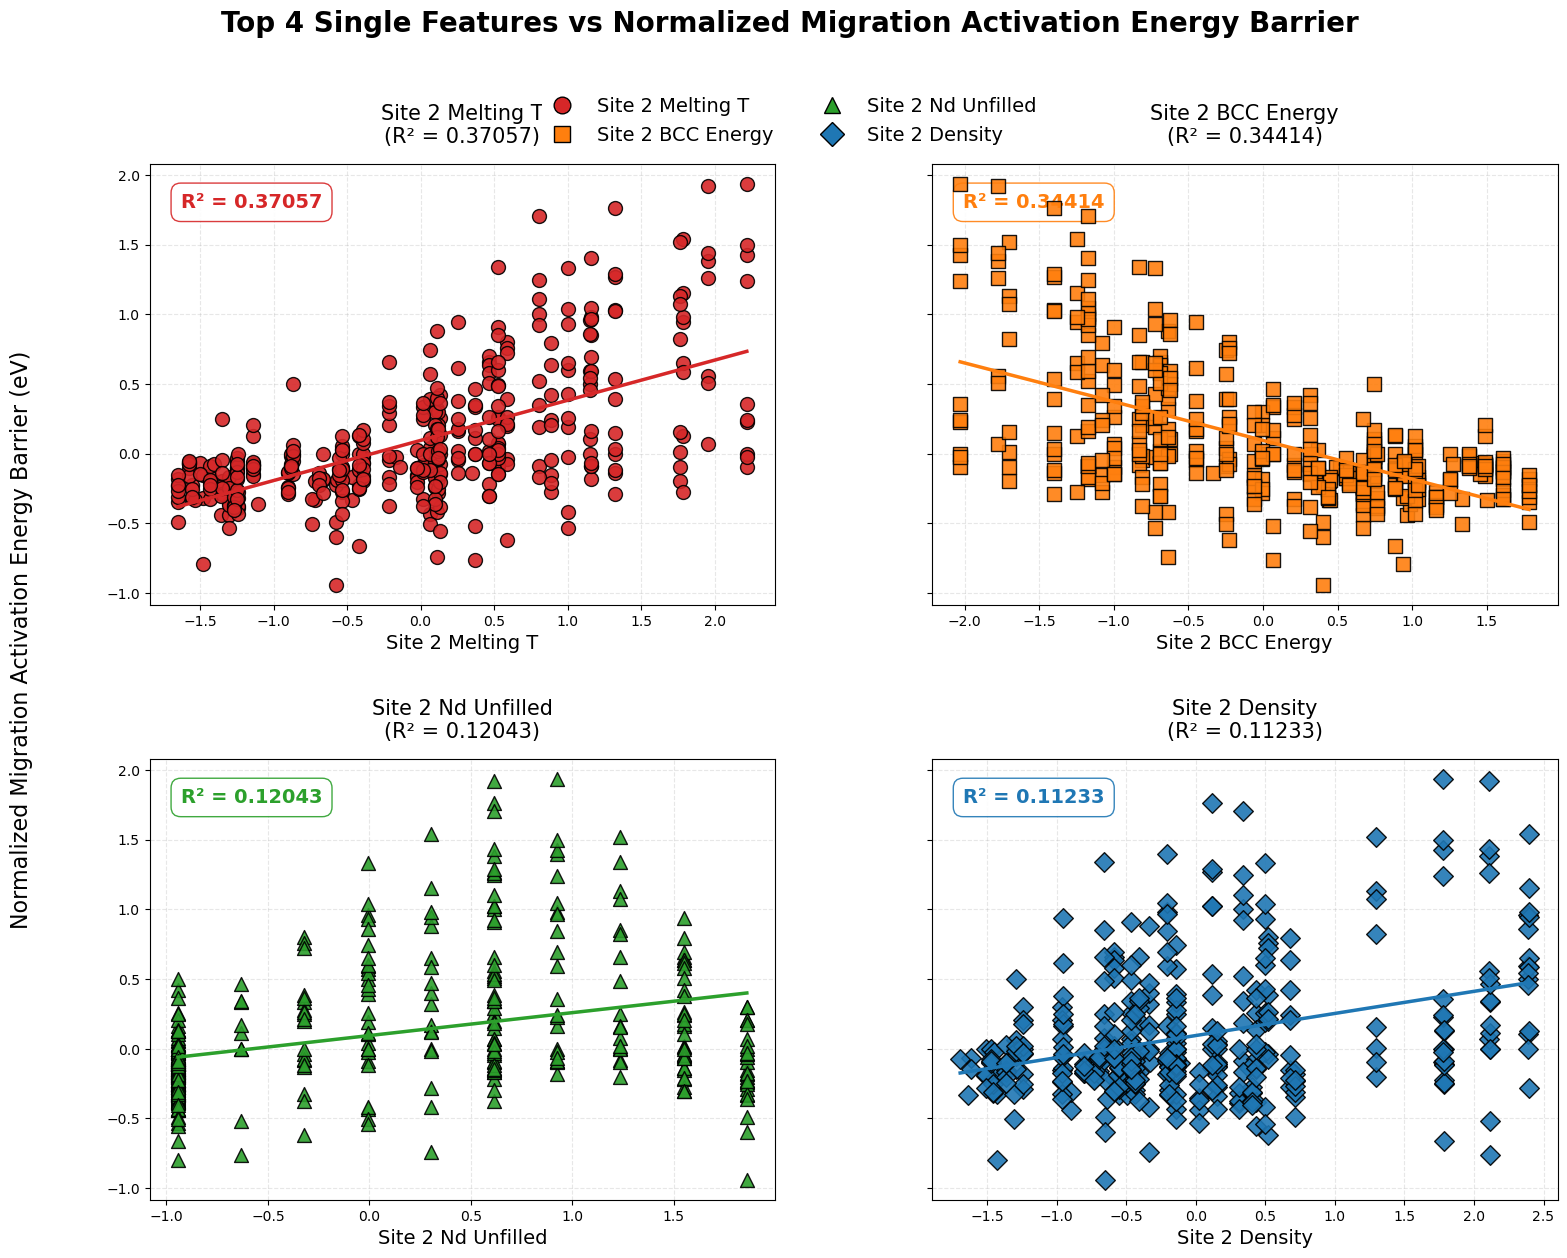

In [71]:

from scipy.stats import linregress, t

df = map_df.copy()         
target = 'Enorm (eV)'

# Make sure df_single exists and has clean column name
df_single = df_single.copy()
if 'R²' in df_single.columns:
    df_single = df_single.rename(columns={'R²': 'R2'})

top_4_features = df_single.head(4).copy()

pretty_names = {
    'Site2_MeltingT': 'Site 2 Melting T',
    'Site2_BCCenergy_pa': 'Site 2 BCC Energy',
    'Site2_Density': 'Site 2 Density',
    'Site2_NdUnfilled': 'Site 2 Nd Unfilled',
    'Site2_Group': 'Site 2 Group',
    'E_raw (eV)': 'Raw Energy',
    'Site1_MendeleevNumber': 'Site 1 Mendeleev Number',
    'CovalentRadius_max_value': 'Max Covalent Radius',
    'IonicRadii_max_value': 'Max Ionic Radius',
    'BoilingT_max_value': 'Max Boiling T',
    'MeltingT_min_value': 'Min Melting T',
    'valence_arithmetic_average': 'Valence (avg)',
    'BCCenergy_pa_composition_average': 'BCC Energy (avg)',
    'BCCenergy_pa_arithmetic_average': 'BCC Energy (arith avg)',
    'Site1_Electronegativity': 'Site 1 Electronegativity',
    'SpecificHeatCapacity_difference': 'ΔSpecific Heat',
}

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
markers = ['o', 's', '^', 'D']

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharey=True)
axes = axes.flatten()

for idx, row in top_4_features.iterrows():
    feat = row['Feature']
    r2 = row['R2']

    ax = axes[idx]
    x = df[feat].values
    y = df[target].values

    result = linregress(x, y)
    slope, intercept = result.slope, result.intercept

    sc = ax.scatter(x, y, color=colors[idx], edgecolor='k', s=100,
                    marker=markers[idx], alpha=0.9, zorder=5,
                    label=pretty_names.get(feat, feat))

    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color=colors[idx], lw=2.5, zorder=6)

    n = len(x)
    se = result.stderr * np.sqrt(1/n + (line_x - x.mean())**2 / ((n-1)*np.var(x)))
    t_val = t.ppf(0.975, n-2)
    margin = t_val * se
    ax.fill_between(line_x, line_y - margin, line_y + margin,
                    color=colors[idx], alpha=0.15, zorder=4)

    ax.set_xlabel(pretty_names.get(feat, feat), fontsize=14)
    ax.set_title(f'{pretty_names.get(feat, feat)}\n(R² = {r2:.5f})', fontsize=15, pad=15)
    ax.grid(True, alpha=0.3, linestyle='--')

    # R² box
    ax.text(0.05, 0.90, f'R² = {r2:.5f}', transform=ax.transAxes,
            fontsize=14, fontweight='bold', color=colors[idx],
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor=colors[idx]))

#shared y
fig.text(0.02, 0.5, 'Normalized Migration Activation Energy Barrier (eV)',
         va='center', ha='center', rotation='vertical', fontsize=16)

plt.suptitle('Top 4 Single Features vs Normalized Migration Activation Energy Barrier',
             fontsize=20, fontweight='bold', y=0.95)

handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor=c, markersize=12, markeredgecolor='k')
           for m, c in zip(markers, colors)]
labels = [pretty_names.get(feat, feat) for feat in top_4_features['Feature']]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.90),
           ncol=2, fontsize=14, frameon=False)

plt.subplots_adjust(left=0.10, right=0.98, top=0.84, bottom=0.10, wspace=0.25, hspace=0.35)
plt.show()

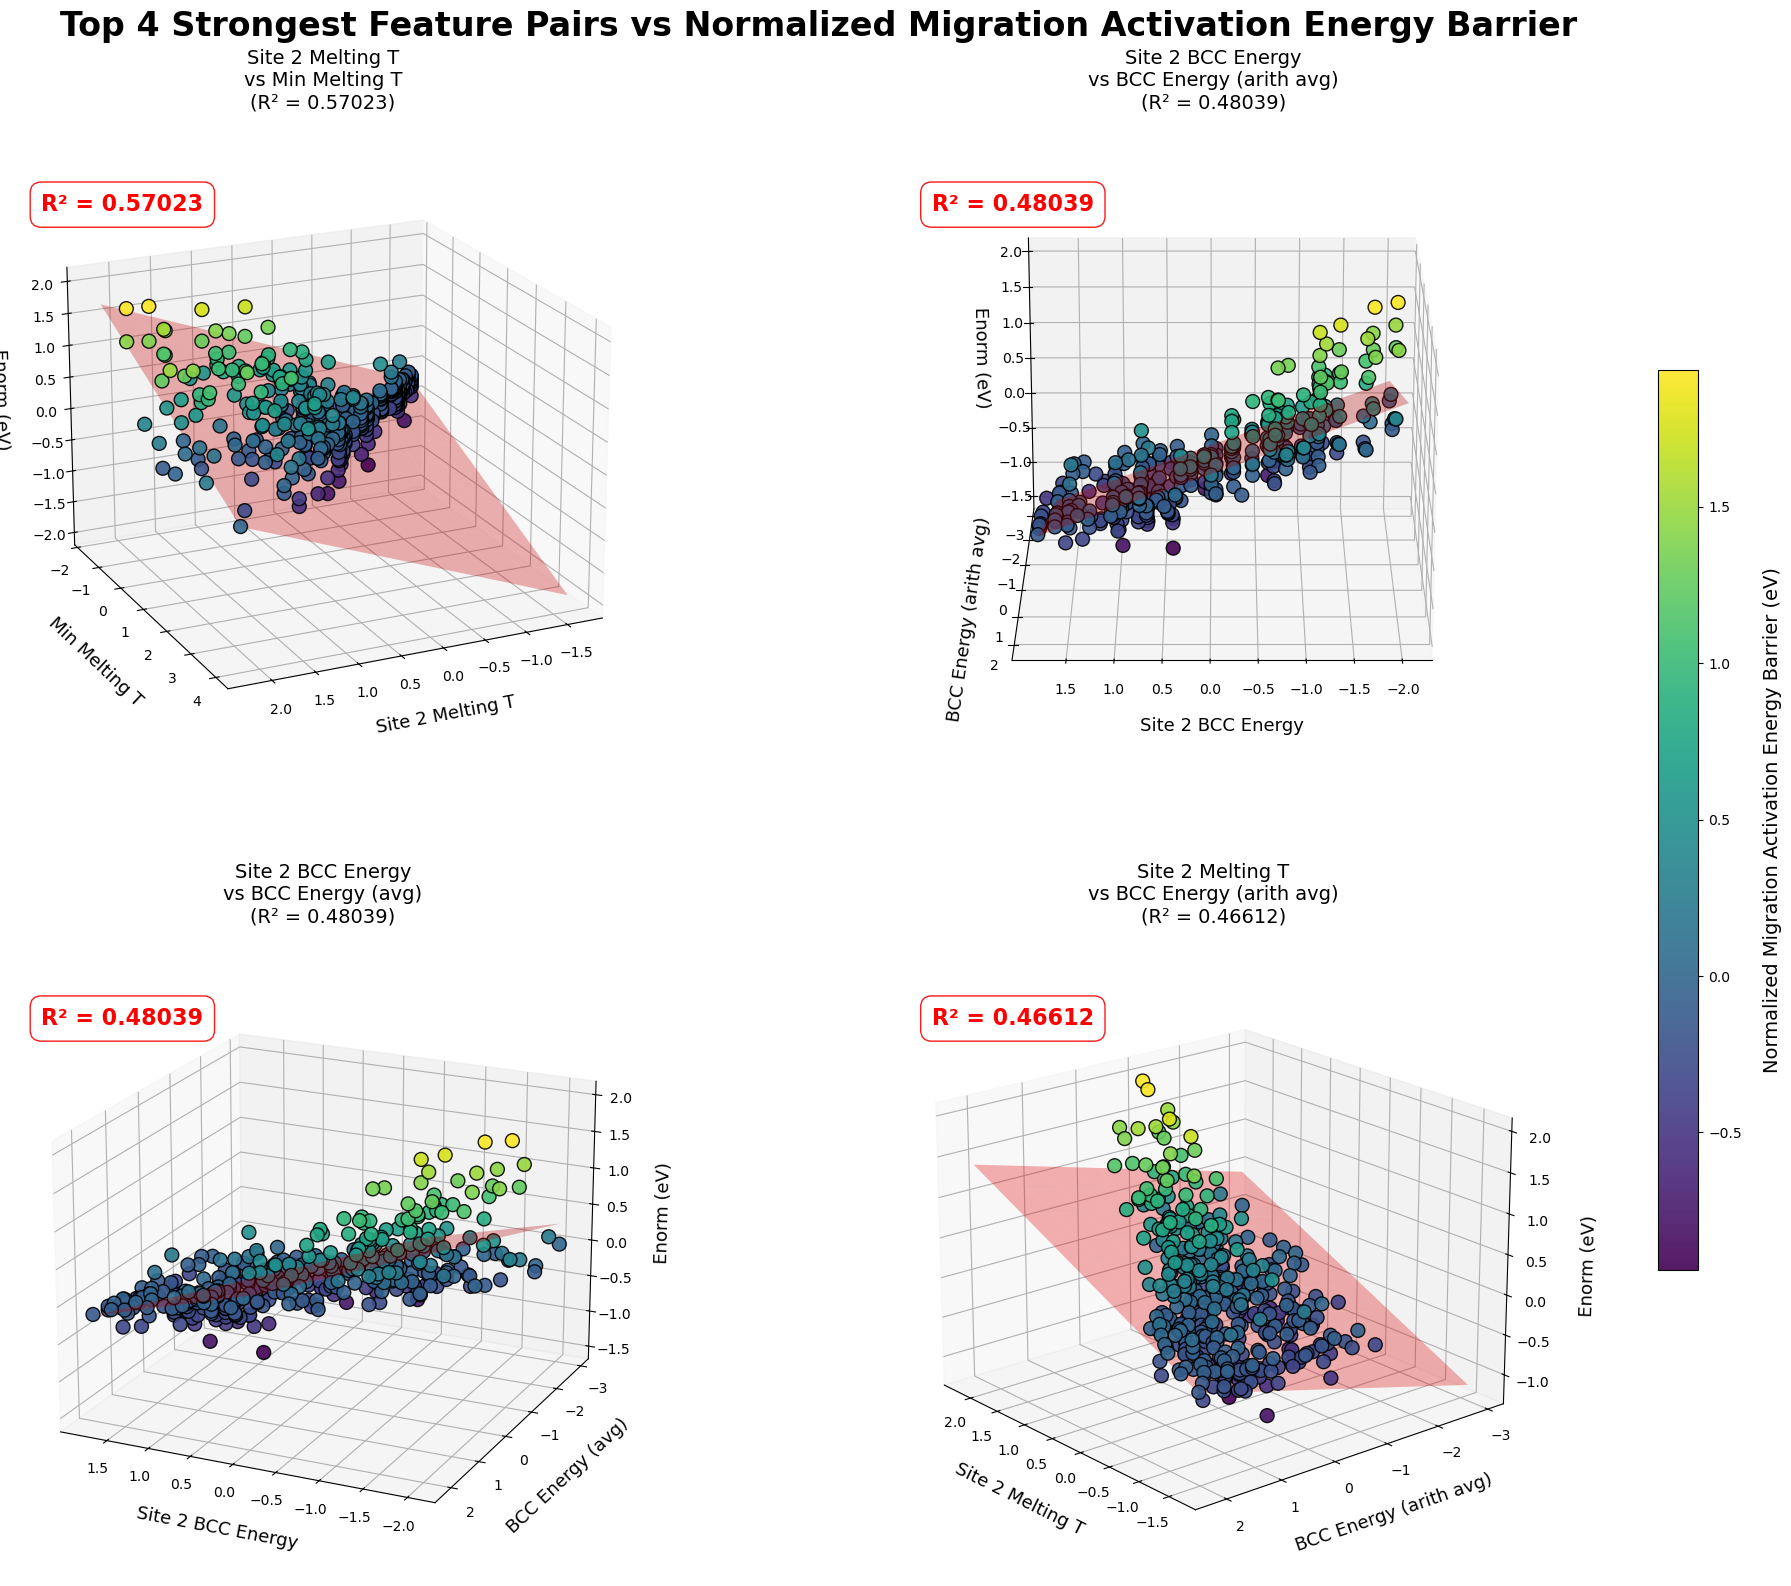

In [72]:
#3D
from mpl_toolkits.mplot3d import Axes3D

df = map_df.copy()          
target = 'Enorm (eV)'


df_pairs = df_pairs.copy()


df_pairs.columns = [col.replace('²', '2').replace(' ', '_') for col in df_pairs.columns]


if 'Feature_1' not in df_pairs.columns:
    df_pairs = df_pairs.rename(columns={'Feature 1': 'Feature_1', 'Feature 2': 'Feature_2', 'R2': 'R2', 'R²': 'R2'})


top_4 = df_pairs.head(4).copy()



fig = plt.figure(figsize=(20, 18))
fig.suptitle('Top 4 Strongest Feature Pairs vs Normalized Migration Activation Energy Barrier',
             fontsize=24, fontweight='bold', y=0.95)

for idx, (_, row) in enumerate(top_4.iterrows(), 1):
    f1 = row['Feature_1']
    f2 = row['Feature_2']
    r2 = row['R2']

    ax = fig.add_subplot(2, 2, idx, projection='3d')

    x = df[f1].values
    y = df[f2].values
    z = df[target].values


    sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=100, edgecolor='k', alpha=0.9, depthshade=False)


    X_fit = np.column_stack((x, y, np.ones(len(x))))
    coeffs = np.linalg.lstsq(X_fit, z, rcond=None)[0]
    a, b, c = coeffs

    x_surf, y_surf = np.meshgrid(np.linspace(x.min(), x.max(), 10),
                                 np.linspace(y.min(), y.max(), 10))
    z_surf = a * x_surf + b * y_surf + c
    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.3, linewidth=0)


    name1 = pretty_names.get(f1, f1)
    name2 = pretty_names.get(f2, f2)
    ax.set_xlabel(name1, fontsize=13, labelpad=12)
    ax.set_ylabel(name2, fontsize=13, labelpad=12)
    ax.set_zlabel('Enorm (eV)', fontsize=13, labelpad=12)
    ax.set_title(f'{name1}\nvs {name2}\n(R² = {r2:.5f})', fontsize=14, pad=20)


    ax.text2D(0.05, 0.88, f'R² = {r2:.5f}', transform=ax.transAxes,
              fontsize=16, fontweight='bold', color='red',
              bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="red", alpha=0.9))

    ax.view_init(elev=20, azim=40 + idx*25)


cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Normalized Migration Activation Energy Barrier (eV)', fontsize=14, labelpad=15)

plt.subplots_adjust(left=0.05, right=0.90, top=0.88, bottom=0.08, wspace=0.1, hspace=0.3)
plt.show()

Discussion: 

Ran a few metrics to determine our candidate features. 

Since correlation is purely statistical, it can have no meaning (say, there are 2 variables, ice-cream sold at the HUB during finals vs frequency of rain in Seattle, they can have a high positive or negative relation, but they are actually irrelevant). Therefore, I tried other metrics to seek more clues. I did linear regression on all features to Enorm and see how much variance in Enorm can be explained by the feature using $R^2$. <br>

A high value of $R^2$ means the feature maps well to Enorm (change of feature changes Enorm predictively). I also ran a brute force test to skim the $R^2$ values with different combinations of features to shed light on any feature interaction and also collinearity between features. Paired $R^2$ can discover relation that are weak when single, and collinearity between features can get us some clue regarding how features relates to each other, but further domain knowledge intepretation is needed.<br> 

For example, $R^2$ collinearity between 'BCCenergy_pa_composition_average' and 'BCCenergy_pa_arithmetic_average' is 1, and it is because they are derived from each other mathematically and would not give significant insights, which shows that we cannot simply just take features with the highest $R^2$ values from different metrics. 

There are a few features that consistently show up in the different top $R^2$ rankings, or has high $R^2$ values when paired with another feature and had features interaction. These features are: 

1.) Site2_MeltingT <br>
2.) Site2_BCCenergy_pa (and how it expressed arithmetically), <br>
3.) Site2_NdUnfilled <br>
4.) Site2_Density<br>

These 4 features are the highest single $R^2$ score with Enorm. Site2_BCCenergy (also in different form like bccenergy_arith/composition) and the other 3 features also has relatively high paired $R^2$ score compared with other features with lower score. Fundamentally, the evaluations provide different insights even though they all end up with a $R^2$ score. 

## Machine learning methods to apply

Now I picked 4 dimensions to work on. <br>

I am aware that the dataset is about predicting continuous variable and not categorical variable, and is a supervised learning issue since I have labelled data. The method that I am going to use is random forest and neural network. But before that, I can try implementing PCA onto my dataset. (although its not needed since my dataset is not too huge or have too much dimension i.e. wouldn't have to worry about curse of dimension)

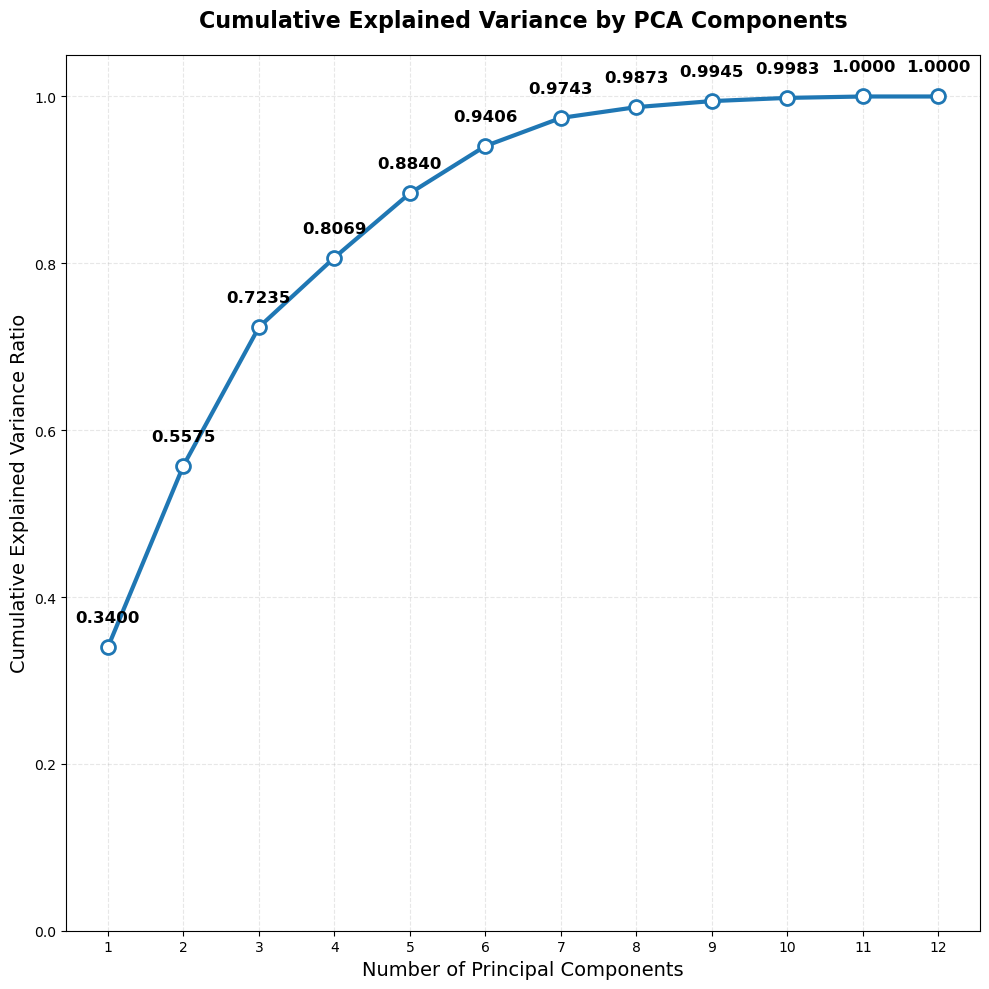

Cumulative Explained Variance:
  1 component(s) → 0.3400 (34.00%)
  2 component(s) → 0.5575 (55.75%)
  3 component(s) → 0.7235 (72.35%)
  4 component(s) → 0.8069 (80.69%)
  5 component(s) → 0.8840 (88.40%)
  6 component(s) → 0.9406 (94.06%)
  7 component(s) → 0.9743 (97.43%)
  8 component(s) → 0.9873 (98.73%)
  9 component(s) → 0.9945 (99.45%)
  10 component(s) → 0.9983 (99.83%)
  11 component(s) → 1.0000 (100.00%)
  12 component(s) → 1.0000 (100.00%)


In [73]:
#PCA 

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # first attempt
# filtered_df = map_df[['Site2_MeltingT',
#                       'Site2_BCCenergy_pa', 'Site2_NdUnfilled',
#                       'Site2_Density']].copy()

# #second attempt 
# filtered_df = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled', 
#                    'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average',
#                    'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii','Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy()

#third attempt
filtered_df = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled', 
                   'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average', 'IonicRadii_max_value',
                   'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii','Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy()

explained_variance_ratio_sum = []
n_components_range = range(1, len(filtered_df.columns) + 1)

for n in n_components_range:
    pca = PCA(n_components=n)
    pca.fit(filtered_df)
    explained_variance_ratio_sum.append(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(10, 10))
plt.style.use('default')

plt.plot(n_components_range, explained_variance_ratio_sum,
         marker='o', linewidth=3, markersize=10,
         color='#1f77b4', markerfacecolor='white', markeredgewidth=2)

plt.title('Cumulative Explained Variance by PCA Components',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=14)
plt.xticks(n_components_range)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, linestyle='--')

for i, var in zip(n_components_range, explained_variance_ratio_sum):
    plt.text(i, var + 0.03, f'{var:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Cumulative Explained Variance:")
for n, var in zip(n_components_range, explained_variance_ratio_sum):
    print(f"  {n} component(s) → {var:.4f} ({var*100:.2f}%)")

It seems that even with 6 components, $94.43%$ of the total explained variance ratio can be achieved. In other words, if there is a necessity to reduce computational cost, 6 components can be enough. <br>

Let's try to build a neural network model.

In [74]:
#Neural network
from tensorflow import keras
import tensorflow as tf
import random as python_random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Input
from tensorflow.keras.metrics import RootMeanSquaredError

import scikeras
from scikeras.wrappers import KerasClassifier
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# # these features gave 0.435 R^2 on parity plot for NN
# filtered_df = map_df[['Site2_MeltingT',
#                       'Site2_BCCenergy_pa', 'Site2_NdUnfilled',
#                       'Site2_Density']].copy().astype(float)


# #these features gave 0.76 R^2
# filtered_df = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled', 
#                    'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average', 
#                    'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii','Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy().astype(float)


#even more features, gave 0.809 R^2 !
filtered_df = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled', 
                   'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average', 'IonicRadii_max_value',
                   'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii','Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy().astype(float)

target = map_df[['Enorm (eV)']].astype(float)

x_train, x_test, y_train, y_test = train_test_split(filtered_df, target,
                                                    test_size=0.20,
                                                    random_state=69)

In [75]:
#hyperparameter tuning

def nn1(neurons1=64,neurons2=64, neurons3= 32, activation1='relu',activation2='relu', activation3='linear'):
    
    model = Sequential()
    
    model.add(Input(shape=(x_train.shape[1],)) )  # Using Input layer
    
    # activation1_instance = activation1
    
    model.add(Dense(neurons1, kernel_initializer='normal', activation=activation1))
    
    # activation2_instance = activation2
    
    model.add(Dense(neurons2, kernel_initializer='normal', activation=activation2))

    model.add(Dense(neurons3, kernel_initializer='normal', activation='relu'))

     # activation3_instance = activation3

    model.add(Dense(1, kernel_initializer='normal', activation=activation3))
    
    optimizer = keras.optimizers.Adam(learning_rate =0.0001)
        
    model.compile(loss='huber', optimizer=optimizer, metrics=['mae', 'RootMeanSquaredError'])    
    
    return model

In [76]:

regressor_search1 = KerasRegressor(
    model=nn1,
    neurons1=64,
    neurons2=64,
    neurons3=32,
    activation1='relu',
    activation2='relu',
    activation3='relu',  # <-- Add this default
    batch_size=32,
    epochs=100,  # Default epochs
    verbose=0
)

print(regressor_search1.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'neurons1', 'neurons2', 'neurons3', 'activation1', 'activation2', 'activation3'])


In [77]:

parameters1 = {
    "neurons1": np.arange(16, 65, 16).tolist(),  
    "neurons2": np.arange(16, 65, 16).tolist(),
    "neurons3": np.arange(16, 33, 8).tolist(),   
    "activation1": ['tanh', 'relu'],
    "activation2": ['tanh', 'relu'],
    "activation3": ['tanh', 'relu','linear'],            
    "batch_size": np.arange(8, 65, 8).tolist(), 
    "epochs": [50, 100, 150],                    
    "verbose": [0]                               
}

In [78]:
# define the randomized search
rnd_search_cv1 = RandomizedSearchCV(
    estimator=regressor_search1,
    param_distributions=parameters1,
    n_iter=30,
    cv=3,
    verbose=1, 
    n_jobs=-1,
    scoring='neg_mean_absolute_error',  
    random_state=69
)

# perform the random search on our training data
rnd_search_cv1.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-12-11 08:05:49.606068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 08:05:52.280401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 08:05:55.016686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use avai

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(activation1='relu', activation2='relu', activation3='relu', batch_size=32, epochs=100, model=<function nn1 at 0x7e90666171a0>, neurons1=64, neurons2=64, neurons3=32, verbose=0),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'activation1': ['tanh', 'relu'],
                                        'activation2': ['tanh', 'relu'],
                                        'activation3': ['tanh', 'relu',
                                                        'linear'],
                                        'batch_size': [8, 16, 24, 32, 40, 48,
                                                       56, 64],
                                        'epochs': [50, 100, 150],
                                        'neurons1': [16, 32, 48, 64],
                                        'neurons2': [16, 32, 48, 64],
                                        'neurons3': [16, 24, 32],
                                        'verbose': [0]},
                   random_state=69, scoring='neg_mean_absolute_error',
                   verbose=1)

In [79]:
print("Best params:", rnd_search_cv1.best_params_)
print("Best score (neg MAE):", rnd_search_cv1.best_score_)

Best params: {'verbose': 0, 'neurons3': 32, 'neurons2': 48, 'neurons1': 16, 'epochs': 150, 'batch_size': 48, 'activation3': 'linear', 'activation2': 'relu', 'activation1': 'relu'}
Best score (neg MAE): -0.15785512071978824


Thing that is annoying about KerasRegressor is that you have to retrain to get history so you can plot training loss.


Epoch 1/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - RootMeanSquaredError: 0.5137 - loss: 0.1255 - mae: 0.3612 - val_RootMeanSquaredError: 0.3970 - val_loss: 0.0748 - val_mae: 0.2614
Epoch 2/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - RootMeanSquaredError: 0.4872 - loss: 0.1136 - mae: 0.3420 - val_RootMeanSquaredError: 0.3965 - val_loss: 0.0747 - val_mae: 0.2615
Epoch 3/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - RootMeanSquaredError: 0.5122 - loss: 0.1274 - mae: 0.3718 - val_RootMeanSquaredError: 0.3961 - val_loss: 0.0745 - val_mae: 0.2616
Epoch 4/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - RootMeanSquaredError: 0.5235 - loss: 0.1308 - mae: 0.3673 - val_RootMeanSquaredError: 0.3957 - val_loss: 0.0744 - val_mae: 0.2617
Epoch 5/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - RootMeanSquaredError: 0.4991 - loss: 0.1200 - mae: 0.3513 - val_RootMeanSquaredError: 0.3952 - val_loss: 0.0743 - val_mae: 0.2618
Epoch 6/75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RootMeanSquaredError: 0.5045 - loss: 0.1217 

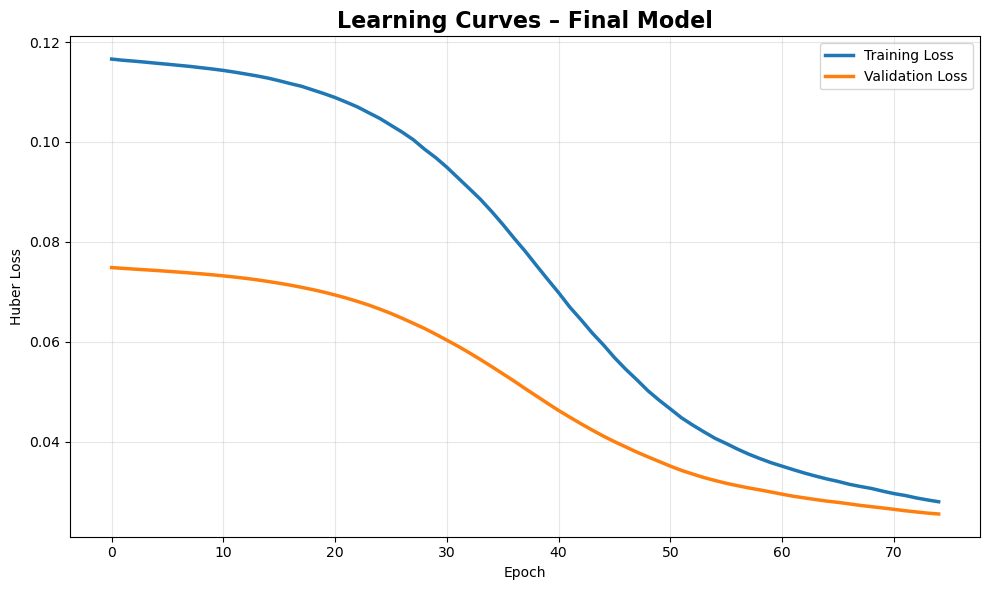

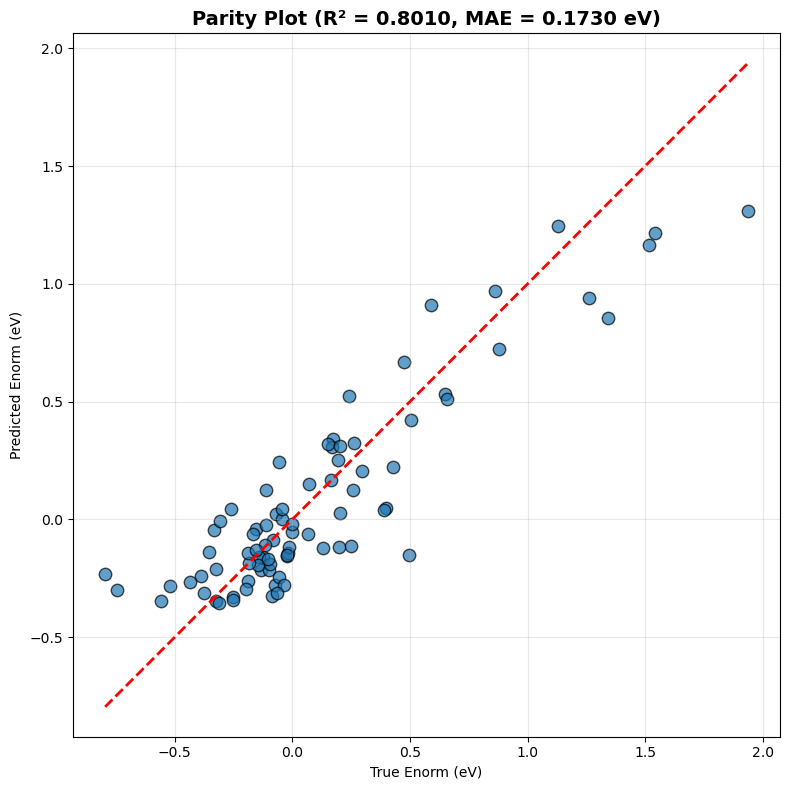

Fold 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
  Fold 1 - R²: 0.5332, MAE: 0.1698, RMSE: 0.2491
Fold 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
  Fold 2 - R²: 0.7675, MAE: 0.1660, RMSE: 0.2175
Fold 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  Fold 3 - R²: 0.6833, MAE: 0.2081, RMSE: 0.2813
Fold 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Fold 4 - R²: 0.7414, MAE: 0.1692, RMSE: 0.2262
Fold 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  Fold 5 - R²: 0.7381, MAE: 0.2022, RMSE: 0.2715

 5-Fold Cross-Validation Results for NN
Mean R²:  0.6927 ± 0.0843
Mean MAE: 0.1831 ± 0.0182
Mean RMSE: 0.2491 ± 0.0247


In [82]:
import sklearn.metrics as metrics
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


best_params = rnd_search_cv1.best_params_

def create_best_model():
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))
    model.add(Dense(best_params['neurons1'], activation=best_params['activation1'],
                    kernel_initializer='normal'))
    model.add(Dense(best_params['neurons2'], activation=best_params['activation2'],
                    kernel_initializer='normal'))
    model.add(Dense(best_params['neurons3'], activation=best_params['activation3'],
                    kernel_initializer='normal'))
    model.add(Dense(1, activation='linear', kernel_initializer='normal'))
   
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='huber', optimizer=optimizer,
                  metrics=['mae', 'RootMeanSquaredError'])
    return model

final_model = create_best_model()
history = final_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=75,
    batch_size=best_params.get('batch_size', 32),
    verbose=1
)

y_pred = final_model.predict(x_test).flatten()
y_true = y_test.values.flatten()
mae = metrics.mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
r2 = metrics.r2_score(y_true, y_pred)
pearson, _ = pearsonr(y_true, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('Learning Curves – Final Model', fontsize=16, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k', s=80)
minmax = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(minmax, minmax, 'r--', lw=2)
plt.xlabel('True Enorm (eV)')
plt.ylabel('Predicted Enorm (eV)')
plt.title(f'Parity Plot (R² = {r2:.4f}, MAE = {mae:.4f} eV)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

X = x_train.to_numpy() if hasattr(x_train, 'to_numpy') else np.asarray(x_train)
y_raw = y_train.to_numpy().flatten() if hasattr(y_train, 'to_numpy') else np.asarray(y_train).flatten()
y = y_raw.reshape(-1, 1)

fold = 5
kf_val = KFold(n_splits=fold, shuffle=True, random_state=10)

r2_scores = []
mae_scores = []
rmse_scores = []

fold_no = 1
for train_idx, val_idx in kf_val.split(X):
    print(f"Fold {fold_no}/{fold}")

    X_train_fold = X[train_idx]
    X_val_fold = X[val_idx]
    y_train_fold = y[train_idx]
    y_val_fold = y[val_idx]

    model = create_best_model()

    model.fit(X_train_fold, y_train_fold,
              epochs=75,
              batch_size=best_params.get('batch_size', 32),
              verbose=0)

    y_pred_fold = model.predict(X_val_fold).flatten()
    y_true_fold = y_val_fold.flatten()

    r2_fold = r2_score(y_true_fold, y_pred_fold)
    mae_fold = mean_absolute_error(y_true_fold, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_true_fold, y_pred_fold))

    r2_scores.append(r2_fold)
    mae_scores.append(mae_fold)
    rmse_scores.append(rmse_fold)

    print(f"  Fold {fold_no} - R²: {r2_fold:.4f}, MAE: {mae_fold:.4f}, RMSE: {rmse_fold:.4f}")
    fold_no += 1

print("\n 5-Fold Cross-Validation Results for NN")
print(f"Mean R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")

final_model.save('final_migration_barrier_nn.keras')


Let's try to build a random forest from decision trees 

The training R² is 0.8925663895639282
The training MAE is 0.11329703956053477
The training RMSE is 0.15307590535916676 

The test R² is 0.813143437124375
The test MAE is 0.16434959884816192
The test RMSE is 0.21496032489625258


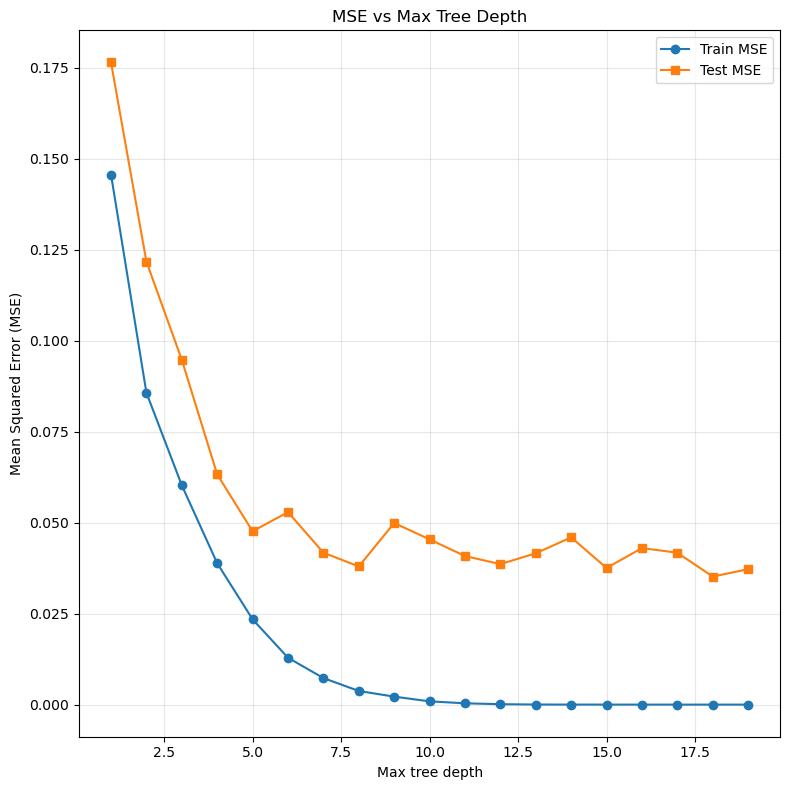

Cross-validation R² scores: [0.73097542 0.81095602 0.84338898 0.62954245 0.77402821]
Mean CV R²: 0.757778217242364
Cross-validation neg MSE scores: [-0.05967497 -0.04438637 -0.03952896 -0.06078781 -0.05145762]
Mean CV MSE: 0.051167148789381556


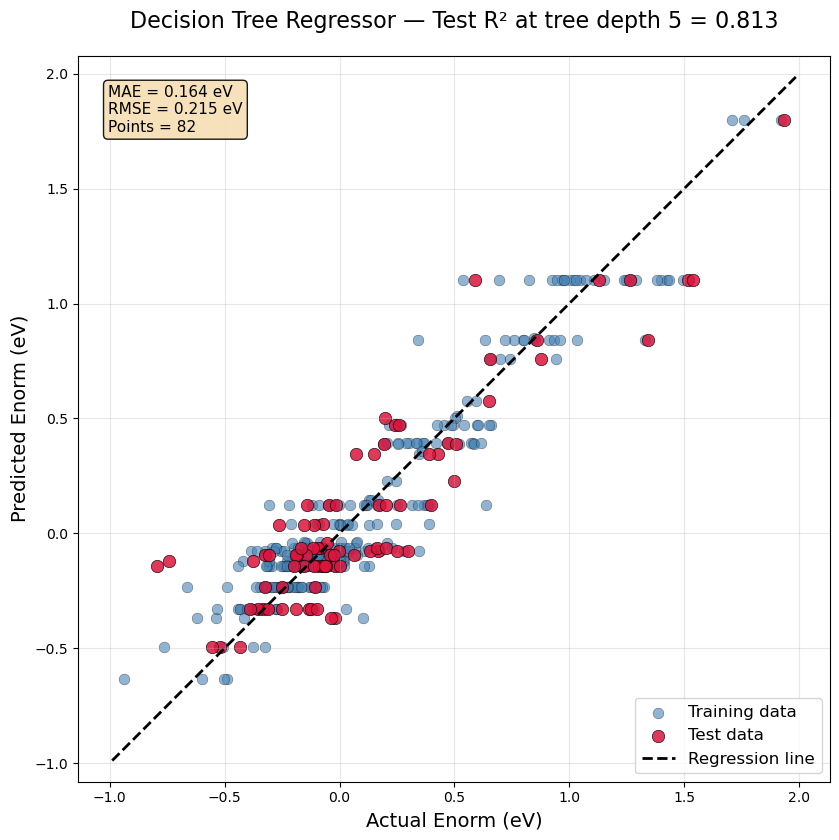

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# #attempt 2 gives 0.821 R^2 at tree_depth 5
# x_dt = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled',
#                'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average',
#                'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii',
#                'Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy().astype(float)


#even more features, decision tree gave 0.813 R^2 
x_dt = map_df[['Site2_MeltingT', 'Site2_BCCenergy_pa', 'Site2_NdUnfilled', 
                   'Site2_Density', 'Site1_MendeleevNumber', 'valence_arithmetic_average', 'IonicRadii_max_value',
                   'Site1_Electronegativity','Site1_MendeleevNumber','Site1_CovalentRadii','Site1_MiracleRadius', 'BCCenergy_pa_arithmetic_average']].copy().astype(float)


y_dt = map_df[['Enorm (eV)']].astype(float)

x_traindt, x_testdt, y_traindt, y_testdt = train_test_split(x_dt, y_dt, test_size=0.2, random_state=69)

DT = tree.DecisionTreeRegressor(max_depth=5)
DT.fit(x_traindt, y_traindt.values.ravel())  # ravel to avoid warnings
dt_trainpred = DT.predict(x_traindt)
dt_testpred = DT.predict(x_testdt)

train_r2 = r2_score(y_traindt, dt_trainpred)
test_r2 = r2_score(y_testdt, dt_testpred)
train_mae = mean_absolute_error(y_traindt, dt_trainpred)
test_mae = mean_absolute_error(y_testdt, dt_testpred)
train_rmse = np.sqrt(mean_squared_error(y_traindt, dt_trainpred))
test_rmse = np.sqrt(mean_squared_error(y_testdt, dt_testpred))

print("The training R² is", train_r2)
print("The training MAE is", train_mae)
print("The training RMSE is", train_rmse, "\n")
print("The test R² is", test_r2)
print("The test MAE is", test_mae)
print("The test RMSE is", test_rmse)

# MSE vs depth plot
train_mse_list = []
test_mse_list = []
trees = np.arange(1, 20, 1)
for t in trees:
    dt_model = tree.DecisionTreeRegressor(max_depth=t)
    dt_model.fit(x_traindt, y_traindt.values.ravel())
    train_pred = dt_model.predict(x_traindt)
    test_pred = dt_model.predict(x_testdt)
    train_mse = mean_squared_error(y_traindt, train_pred)
    test_mse = mean_squared_error(y_testdt, test_pred)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

plt.figure(figsize=(8, 8))
plt.plot(trees, train_mse_list, marker='o', label='Train MSE')
plt.plot(trees, test_mse_list, marker='s', label='Test MSE')
plt.legend()
plt.xlabel('Max tree depth')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Max Tree Depth')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fold = 5
kf_val = KFold(n_splits=fold, shuffle=True, random_state=10)
dt_r2_scores = cross_val_score(DT, x_dt, y_dt.values.ravel(), cv=kf_val, scoring='r2')
print("Cross-validation R² scores:", dt_r2_scores)
print("Mean CV R²:", dt_r2_scores.mean())

dt_mse_scores = cross_val_score(DT, x_dt, y_dt.values.ravel(), cv=kf_val, scoring='neg_mean_squared_error')
print("Cross-validation neg MSE scores:", dt_mse_scores)
print("Mean CV MSE:", -dt_mse_scores.mean())

plt.figure(figsize=(8.5, 8.5))

y_dt_min = y_dt.min().item()
y_dt_max = y_dt.max().item()
trainpred_min = dt_trainpred.min()
trainpred_max = dt_trainpred.max()
testpred_min = dt_testpred.min()
testpred_max = dt_testpred.max()

overall_min = min(y_dt_min, trainpred_min, testpred_min) - 0.05
overall_max = max(y_dt_max, trainpred_max, testpred_max) + 0.05

plt.scatter(y_traindt, dt_trainpred,
            color='steelblue', alpha=0.6, s=60, label='Training data', edgecolor='k', linewidth=0.3)

plt.scatter(y_testdt, dt_testpred,
            color='crimson', alpha=0.85, s=80, label='Test data', edgecolor='k', linewidth=0.5)

plt.plot([overall_min, overall_max], [overall_min, overall_max],
         color='black', linestyle='--', linewidth=2, label='Regression line')

plt.title(f'Decision Tree Regressor — Test R² at tree depth 5 = {test_r2:.3f}', fontsize=16, pad=20)
plt.xlabel('Actual Enorm (eV)', fontsize=14)
plt.ylabel('Predicted Enorm (eV)', fontsize=14)

textstr = f'MAE = {test_mae:.3f} eV\nRMSE = {test_rmse:.3f} eV\nPoints = {len(y_testdt)}'
plt.text(0.04, 0.96, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Discussion

This model I build is a supervised machine learning regression model. Unlike what we learnt in class(using neural network and random forest for classification), I used both the machine learning methods for regression since, instead of classification, I need to predict a line of float numbers. The reason why I chose neural network and decision tree because it was obvious that the relationship between the features and Enorm isn't linear, and linear regression wouldn't be able to map the relationship well. Neural networks and decision trees are widely used for non-linear relationship prediction in data. <br>

To reiterate, we are building a model that could predict the Enorm migration barrier activation energy using different related features I can find in the dataset. <br>

On the discussion before I start training a model, I explained my train of thought on how I picked the 4 features. The 4 features are: <br>

site2meltingT, site2bccenergy, site2ndunfilled, site2density <br>

The key performance metric I used for my regression models is the $R^2$ score between predicted Enorm and actual Enorm value, as it measures the proportion of variance in actual Enorm from predicted Enorm. Since it is a supervised machine learning, we have ground truth predicted value, and how different our predicted values to the ground truth will be a good metric to determine the model performance. I also used mean absolute error and mean-squared error to check the error percentage (accuracy is not applicable as a metric in a regression model).
                        
The first $R^2$ from the predicted vs actual was an awful 0.435 $R^2$ while using just the 4 features for my neural network. Not only that I used the hyperparameter tuning we learned in class to pick the optimal activation functions and neurons for the layers, while using 4 features, even if I raised my training epochs to 200, the validation loss and training loss comes to a plateau after 50 epochs. Since shape of validation loss curve didn't spike and k-fold cross validation average $R^2$ was consistent (awfully low, mean 0.321) with the $R^2$ score, I believe that the model didn't overfit, but instead underfit.<br> 

However, my decision tree performed really well and had test $R^2$ of 0.8 and mean cross-validation $R^2$ of 0.758. <br>


Then, I thought I could add more features and check whether my mode will perform better - and it did which is expected. I introduced more features that are related to bonding energy of the atoms:

| Category                          | Feature                              |
|-----------------------------------|--------------------------------------|
| Site 2 Properties                 | `Site2_MeltingT`                     |
|                                   | `Site2_BCCenergy_pa`                 |
|                                   | `Site2_NdUnfilled`                   |
|                                   | `Site2_Density`                      |
| Site 1 Properties                 | `Site1_MendeleevNumber`              |
|                                   | `Site1_Electronegativity`            |
|                                   | `Site1_CovalentRadii`                |
|                                   | `Site1_MiracleRadius`                |
| Mixed / Average Properties        | `valence_arithmetic_average`         |
|                                   | `BCCenergy_pa_arithmetic_average`    |


and the predicted vs actual $R^2$ became 0.809, with average cross validation $R^2$ of 0.7279 ± 0.0766. I believe adding more related features, such as Ionicradii_max_value will also help, but adding too many features could cause overfitting. 

For my decision tree, test MSE plateaued at tree depth 5 for all features, but it always shown consistent test $R^2$ of ~0.8 and average cross validation $R^2$ of ~0.75 across all 3 attempts with different number of features, despite NN performing badly with fewer features. <br>

To answer why random forest outperforms NN at fewer features, (from the internet), it is because NN requires a lot of data and learn non-linearities without underfitting, and our dataset has a small sample size. Our dataset is also tabulated, where random forest excels compared to NN, where NN usually does well on voices/images. Random forest also works well and robustly on small noisy datasets as it handles low data volumes robustly by acceraging predictions and reducing variance, where NN can plateau early (underfit) working on small, noisy datasets. However, NN is really good at working with huge, complex datasets with hierarchy where random forest might not excel. <br>

Bottom line is, using the correct model based on the nature of the dataset you have. Neural network is suitable for large, complex datasets, and random forest is more suitable for small, noisy data. 




## Conclusion



With domain-knowledge-guided feature selection, we hypothesized that it is possible to predict Enorm level if given data of properties related to bonding strength, such as melting point, orbital filling status, radii of solute atom, electronegativity of the solute atom and etc, since bonding energy is what will dictate how much energy is needed for an atom to 'escape'. <br>

These properties, when compared to Enorm individually, weren't able to explain much of the variance of Enorm, but when used to predict Enorm together, they were able to explain majority (80%) of the variance in Enorm. Although not absolute or publication-level accuracy, this supervised machine learning model validates our hypothesis as strong and reliable. Besides that, this project was a good example to prove how random forest outperforms neural network in small, noisier sample.